<a href="https://colab.research.google.com/github/lucyintheskypy/get-osm-data-frontend/blob/main/Asia_Korail_topology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
!pip install momepy
import momepy as mm
import pyproj
!pip install osmnx
import osmnx as ox
import libpysal
from shapely.geometry import box
from time import time
!pip install PyDrive
!pip install clustergram
from clustergram import Clustergram
!pip install folium matplotlib mapclassify
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show
from scipy.spatial.distance import euclidean


In [ ]:
"""
Setting for google colab - remove if you use local settings
"""
# The path of your project on google drive
path_project = "/content/drive/MyDrive/cartography msc/Thesis TUM 2024/momepy/"

# Connect colab with your google drive
from google.colab import drive
drive.mount('/content/drive')

# Set the project path as current working directory
import os
os.chdir(path_project)
print("Current files under the working directory:", os.listdir())

Mounted at /content/drive
Current files under the working directory: ['case_studies.csv', 'cache', 'case_studies3.csv', 'Brasilia.gpkg', 'results', '01_morphometrics.ipynb', 'case_studies.gsheet', 'Asu.csv', 'Case_of_studies.gsheet', 'slums.csv', 'morphometrics_slums.ipynb', 'examples.ipynb', 'slums.gsheet', 'Chacarita_morphometrics.ipynb', 'Africa_Katanga_Morphometrics.ipynb', 'Southametica_Bañado Sur_Morphometrics.ipynb', 'Asia_Korail_Morphometrics.ipynb']


# Usage of osmnx to get the data for example and after preprocessing of building layer will generate tessellation layer.

In [ ]:
point = (23.784425, 90.408570)
dist = 700
gdf = ox.geometries.geometries_from_point(point, dist=dist, tags={'building':True})
gdf2 = ox.geometries.geometries_from_point(point, dist=dist, tags={'residential':['irregular_settlement']})
gdf_projected = ox.projection.project_gdf(gdf)
gdf_projected_2 = ox.projection.project_gdf(gdf2)
buildings = gdf_projected[gdf_projected.geom_type.isin(['Polygon', 'MultiPolygon'])]
Korail = gdf_projected_2[gdf_projected_2.geom_type.isin(['Polygon', 'MultiPolygon'])]

buildings['uID'] = mm.unique_id(buildings)
Korail['uID'] = mm.unique_id(Korail)
limit = mm.buffered_limit(buildings)
tessellation = mm.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

<ipython-input-5-5bca909e802b>:3: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries.geometries_from_point(point, dist=dist, tags={'building':True})
<ipython-input-5-5bca909e802b>:4: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf2 = ox.geometries.geometries_from_point(point, dist=dist, tags={'residential':['irregular_settlement']})
/usr/local/lib/python3.10/dist-packages/geopan

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


<ipython-input-5-5bca909e802b>:13: UserWarning: Tessellation does not fully match buildings. 11 element(s) collapsed during generation - unique_id: {591, 7631, 8850, 8793, 9376, 8674, 8877, 9198, 9325, 9326, 9202}.
  tessellation = mm.Tessellation(buildings, unique_id='uID', limit=limit).tessellation


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

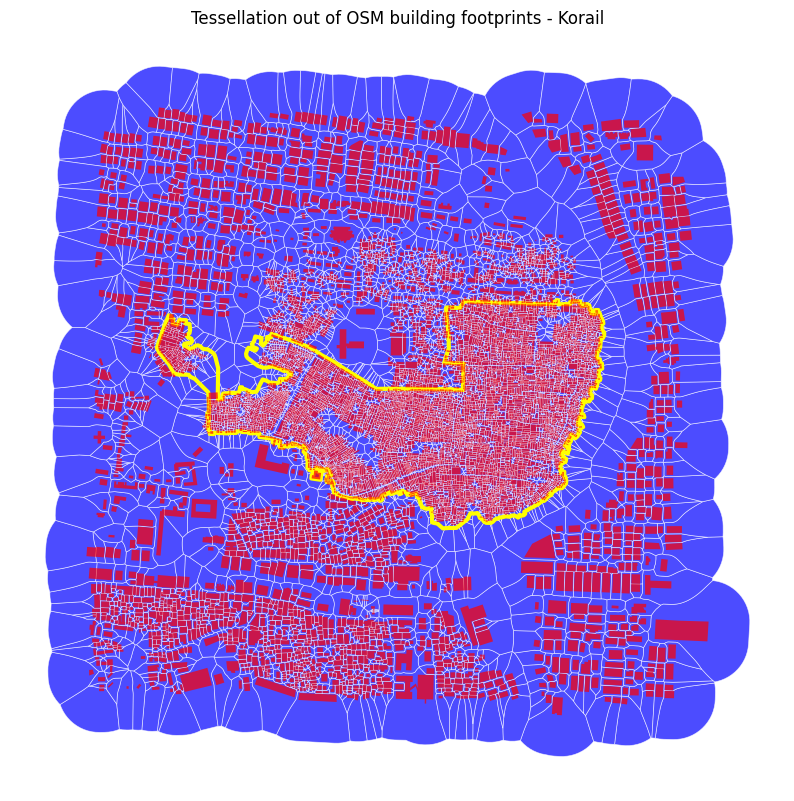

In [ ]:
#Plot
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', linewidth=0.5, facecolor='blue', alpha=.7)
Korail.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=3)
buildings.plot(ax=ax, color='red', alpha=.7)
plt.title('Tessellation out of OSM building footprints - Korail')
ax.set_axis_off()
plt.show()

In [ ]:
# Ensure the projected data is in GeoDataFrame format
if not isinstance(gdf_projected, gpd.GeoDataFrame):
    gdf_projected = gpd.GeoDataFrame(gdf_projected)


# Filter for polygons and multipolygons
buildings = gdf_projected[gdf_projected.geom_type.isin(['Polygon', 'MultiPolygon'])]


# Ensure buildings is GeoDataFrame
if not isinstance(buildings, gpd.GeoDataFrame):
    buildings = gpd.GeoDataFrame(buildings)


buildings['uID'] = mm.unique_id(buildings)
limit = mm.buffered_limit(buildings)


# Centroids of the buildings
def multipolygon_centroid(geom):
    if geom.geom_type == 'MultiPolygon':
        return geom.convex_hull.centroid
    else:
        return geom.centroid

buildings['centroid'] = buildings.geometry.apply(multipolygon_centroid)

# Create a GeoDataFrame for the centroids
centroids_gdf = gpd.GeoDataFrame(geometry=buildings['centroid'], crs=buildings.crs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


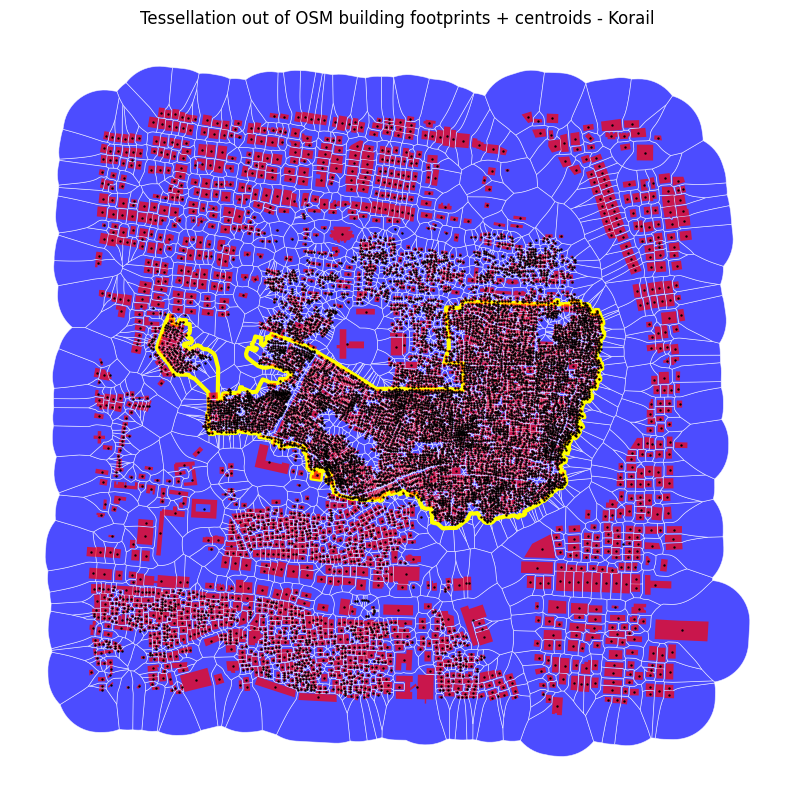

In [ ]:
# Plot
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', linewidth=0.5, facecolor='blue', alpha=.7)
Korail.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=3)
buildings.plot(ax=ax, color='red', alpha=.7)
centroids_gdf.plot(ax=ax, color='black', markersize=0.5, marker='o', label='Centroids')
plt.title('Tessellation out of OSM building footprints + centroids - Korail')
ax.set_axis_off()
plt.show()

# Delaunay Triangulation

In [ ]:
#Coordinates based on the centroids of the buildings
coordinates = np.column_stack((centroids_gdf.geometry.x, centroids_gdf.geometry.y))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from scipy.spatial import Delaunay
tri = Delaunay(coordinates)

# Create a networkx graph out of the Delaunay triangulation
G = nx.Graph()

# Add edges to the graph
for simplex in tri.simplices:
    for i in range(3):
        for j in range(i + 1, 3):
            G.add_edge(simplex[i], simplex[j])

# Get positions of the nodes for plotting
positions = {i: (coordinates[i, 0], coordinates[i, 1]) for i in range(len(coordinates))}



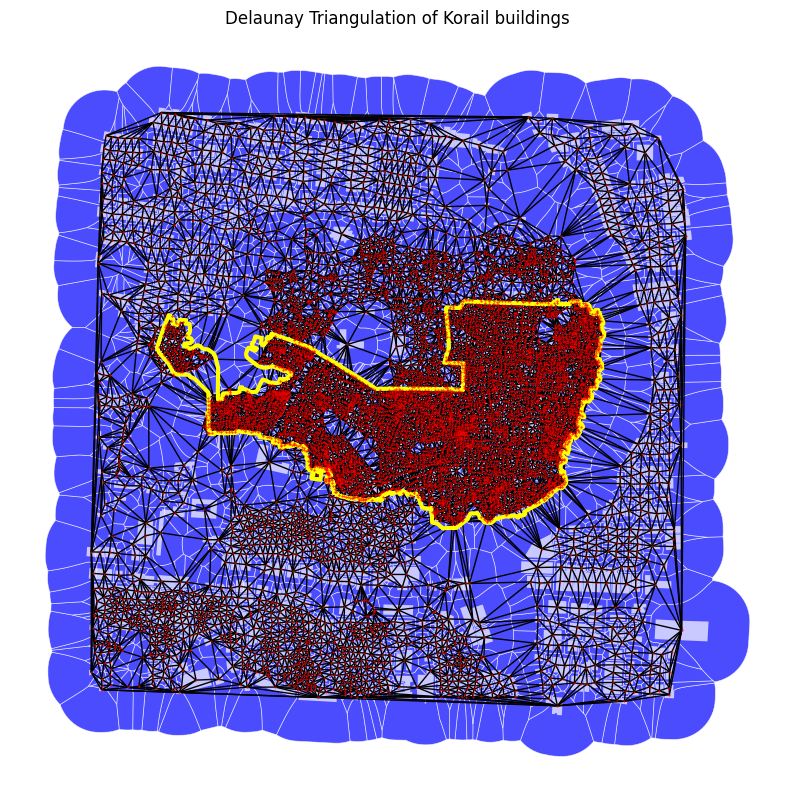

In [ ]:
# Plot
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', linewidth=0.5, facecolor='blue', alpha=.7)
buildings.plot(ax=ax, color='white', alpha=.7)
# Edges of the Delaunay triangulation
nx.draw(G, pos=positions, node_size=0.2, node_color='red', edge_color='black')
Korail.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=3)
plt.title('Delaunay Triangulation of Korail buildings')
plt.show()

# Weighted distance

In [ ]:
from scipy.spatial.distance import euclidean
!pip install shapely
from shapely import LineString

# Add edges to the graph with weights based on Euclidean distance
for simplex in tri.simplices:
    for i in range(3):
        for j in range(i + 1, 3):
            p1 = coordinates[simplex[i]]
            p2 = coordinates[simplex[j]]
            distance = euclidean(p1, p2) #scipy
            G.add_edge(simplex[i], simplex[j], weight=distance) #networkx

# Extract edges with their weights
edges = []
for u, v, data in G.edges(data=True):
    line = LineString([coordinates[u], coordinates[v]])
    edges.append({'geometry': line, 'weight': data['weight']})

# Geodataframe of edges
gdf_edges = gpd.GeoDataFrame(edges)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

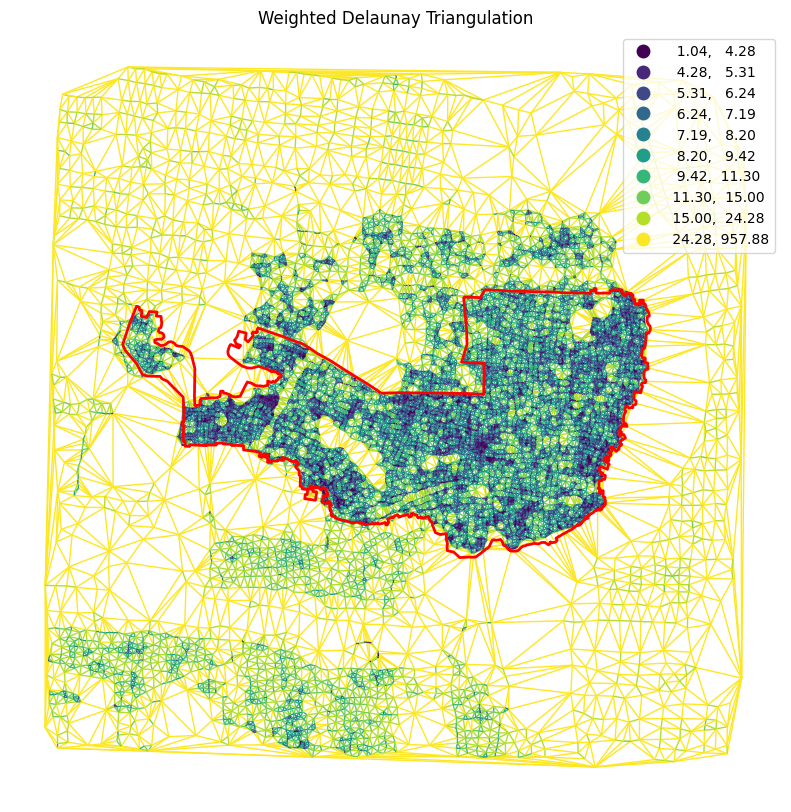

In [ ]:
#Plot
f, ax = plt.subplots(figsize=(10, 10))
Korail.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, zorder=10)

# centroids_gdf.plot(ax=ax, color='black', markersize=0.5, marker='o', label='Centroids', zorder=5)

gdf_edges.plot(ax=ax, column='weight', legend=True, scheme='quantiles', k=10, cmap='viridis', linewidth=1, zorder=0)

plt.title('Weighted Delaunay Triangulation')
ax.set_axis_off()
plt.show()

Result: smaller distances inside the slum

# Nodes weighted

In [ ]:
from matplotlib.patches import Patch
# Color node points by the number of connections
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: ' + str(len(adjacencies[1])))



/usr/lib/python3.10/subprocess.py:1072: ResourceWarning: subprocess 1129 is still running
  _warn("subprocess %s is still running" % self.pid,
/usr/local/lib/python3.10/dist-packages/matplotlib/_api/__init__.py:156: ResourceWarning: unclosed file <_io.FileIO name=44 mode='wb' closefd=True>
  for t, s in zip(target_shape, data_shape)
/usr/local/lib/python3.10/dist-packages/matplotlib/_api/__init__.py:156: ResourceWarning: unclosed file <_io.FileIO name=45 mode='rb' closefd=True>
  for t, s in zip(target_shape, data_shape)
<ipython-input-34-b677a31d00ec>:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Number of Connections')


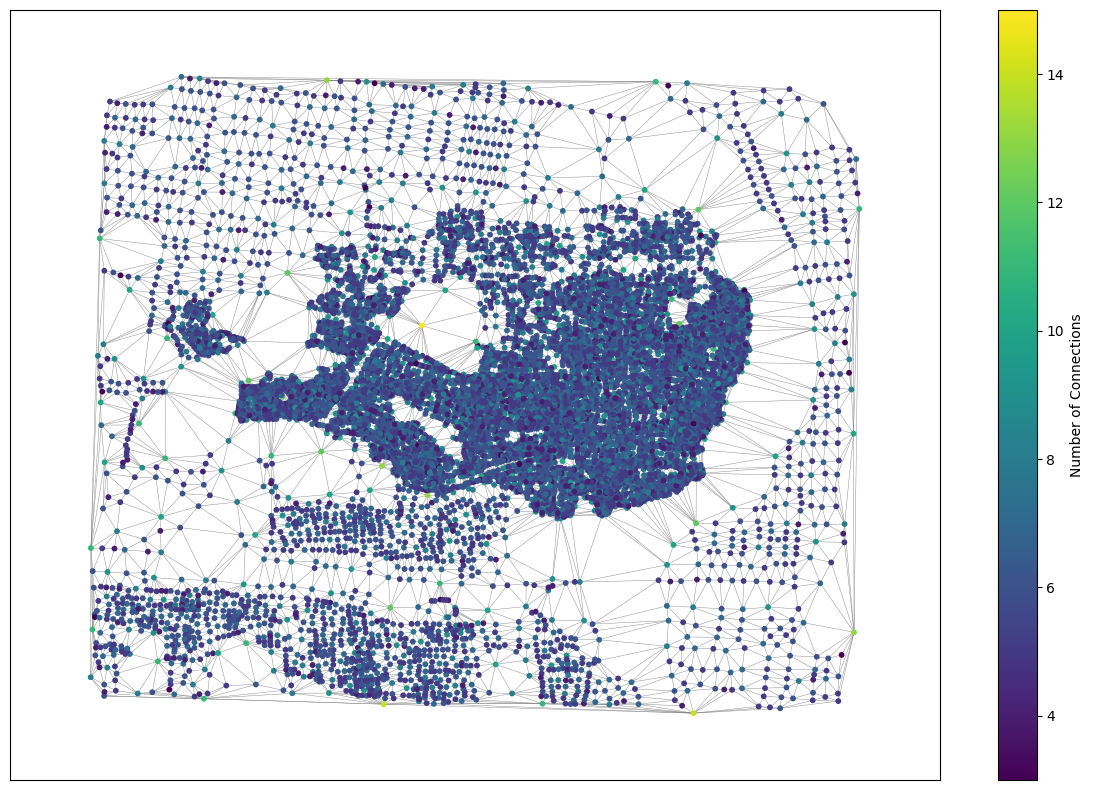

In [ ]:
# Plot
plt.figure(figsize=(15, 10))
Korail.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, zorder=10)
nodes = nx.draw_networkx_nodes(G, pos=positions, node_color=node_adjacencies, cmap=plt.cm.viridis, node_size=10)
edges = nx.draw_networkx_edges(G, pos=positions, width=0.3, edge_color='grey')  # Set the edge color to grey
# labels = nx.draw_networkx_labels(G, pos=positions, font_size=10)


sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_adjacencies), vmax=max(node_adjacencies)))
sm.set_array([])
plt.colorbar(sm, label='Number of Connections')

plt.show()

Result: less number of connections between nodes (building centroids) in slum area